In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.models.pipelines.sdes_samplers.samplers import TauLeaping
from conditional_rate_matching import results_path
from torchvision.utils import make_grid

from conditional_rate_matching.configs.experiments_configs.crm.crm_experiments_nist import experiment_nist
from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat_config import (ConstantThermostatConfig, 
                                                                                         PeriodicThermostatConfig,
                                                                                         ExponentialThermostatConfig,
                                                                                         PolynomialThermostatConfig,
                                                                                         PlateauThermostatConfig
                                                                                         )

def generate_samples(trained_model, 
                     x_test,
                     num_timesteps=100, 
                     time_epsilon=0.0,
                     device="cpu"):
    
    experiment_dir = os.path.join(results_path,"crm", trained_model)
    crm = CRM(experiment_dir=experiment_dir, device=device)
    crm.config.pipeline.time_epsilon = time_epsilon
    crm.config.pipeline.num_intermediates = num_timesteps
    crm.config.pipeline.number_of_steps = num_timesteps

    x_1, x_t, t = crm.pipeline(x_test.shape[0], 
                               return_intermediaries=True, 
                               train=False, 
                               x_0=x_test)
    
    x_1 = x_1.view(-1, 1, 28, 28)
    x_t = x_t.view(-1, x_t.shape[1], 1, 28, 28)
    return x_1, x_t, t

def mnist_noise_bridge(path, 
                       x_input, 
                       num_timesteps=1000,  
                       time_epsilon=0.0,
                       num_img=5,
                       num_timesteps_displayed=20,
                       save_path=None):
    
    img_1, img_hist, time_steps = generate_samples(path, x_input[:num_img], num_timesteps=num_timesteps,  time_epsilon=time_epsilon, device=x_input.device)
    _, axs = plt.subplots(num_img, num_timesteps_displayed+2, figsize=(num_timesteps_displayed, num_img))
    N = img_hist.size(1)
    dt = N // num_timesteps_displayed
    
    for j, idx in enumerate(np.arange(0, N+1, dt)):
        if j<num_timesteps_displayed:
            tau = time_steps[idx]
            images = img_hist[:, idx, :]
        else:
            tau = time_steps[-1]
            images = img_hist[:, -1, :]
            
        for i in range(num_img):
            img = images[i].detach().cpu().numpy()
            axs[i, j].imshow(img.squeeze(), cmap='gray')
            if i == 0: axs[i, j].set_title(r'$\tau = {0}$'.format(round(tau.item(),2)))
            axs[i, j].axis('off')
    
    j = num_timesteps_displayed + 1
    for i in range(num_img):
        axs[i, j].imshow(img_1[i].detach().cpu().numpy().squeeze(), cmap='gray')
        axs[i, j].axis('off')

    plt.tight_layout()
    if save_path is None: plt.show()
    else: plt.savefig(save_path+'/bridge_example.png')

def mnist_conditional_bridge(source, 
                             target, 
                             thermostat="constant", 
                             thermostat_params=(.1,0),
                             figsize=None, 
                             num_timesteps=100,
                             num_timesteps_displayed=10,
                             save_path=None):
    
    config = experiment_nist(dataset_name="mnist",temporal_network_name="mlp")
    
    if thermostat == 'exponential':
        config.thermostat = ExponentialThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
        config.thermostat.max = thermostat_params[1]
    elif thermostat == 'constant':
        config.thermostat = ConstantThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
    elif thermostat == 'periodic':
        config.thermostat = PeriodicThermostatConfig()
        config.thermostat.gamma= thermostat_params[0]
        config.thermostat.max = thermostat_params[1]
    elif thermostat == 'polynomial':
        config.thermostat = PolynomialThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
        config.thermostat.exponent = thermostat_params[1]
    elif thermostat == 'plateau':
        config.thermostat = PlateauThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
        config.thermostat.slope = thermostat_params[1]
        config.thermostat.shift = thermostat_params[2]

    crm = CRM(config)
    crm.config.pipeline.number_of_steps = num_timesteps
    crm.config.pipeline.num_intermediates = num_timesteps

    rate_model = lambda x, t: crm.forward_rate.conditional_transition_rate(x, target.view(-1, 28*28), t)
    img_1, img_hist, _, _ = TauLeaping(crm.config, rate_model, source.view(-1, 28*28), forward=True)

    N = img_hist.size(1)
    dt = N // num_timesteps_displayed

    num_img = source.shape[0]
    img_1 = img_1.view(-1, 1, 28, 28)
    img_hist = img_hist.view(-1, N, 1, 28, 28)

    _, axs = plt.subplots(num_img, num_timesteps_displayed+2, figsize=(num_timesteps_displayed, num_img) if figsize is None else figsize)

    for j, idx in enumerate(np.arange(0, N+1, dt)):
        if j<num_timesteps_displayed:
            images = img_hist[:, idx, :]
        else:
            images = img_hist[:, -1, :]
            
        for i in range(num_img):
            img = images[i].detach().cpu().numpy()
            axs[i, j].imshow(img.squeeze(), cmap='gray')
            axs[i, j].axis('off')
    
    j = num_timesteps_displayed + 1
    for i in range(num_img):
        axs[i, j].imshow(img_1[i].detach().cpu().numpy().squeeze(), cmap='gray')
        axs[i, j].axis('off')

    plt.tight_layout()
    if save_path is None: plt.show()
    else: plt.savefig(save_path+'/conditional_markov_example.png')


def get_mnist_test_samples(trained_model, 
                           which = 'source', # 'source' or 'target
                           class_label=None, 
                           sample_size=800, 
                           device="cpu"):
    
    experiment_dir = os.path.join(results_path,"crm", trained_model)
    crm = CRM(experiment_dir=experiment_dir, device=device)
    images = []
    source = crm.dataloader_0.test()
    target = crm.dataloader_1.test()

    for batch in source if which == 'source' else target:
        if len(batch) == 2:
            sample, labels = batch[0], batch[1]
            selected_images = sample[labels == class_label] if class_label is not None else sample 
            images.append(selected_images)
        else:
            sample = batch[0].view(-1, 1, 28, 28)
            images.append(sample)

    return torch.cat(images, dim=0)[:sample_size].to(device) #if labeled else torch.tensor(images, device=device)


def mnist_grid(sample, save_path='.', num_img=5, nrow=8, figsize=(10,10)):
    _, _= plt.subplots(1,1, figsize=figsize)
    sample = sample[:num_img]
    img = make_grid(sample, nrow=nrow)
    npimg = np.transpose(img.detach().cpu().numpy(),(1,2,0))
    plt.imshow(npimg)
    plt.axis('off')
    plt.savefig(save_path+'/selected_sample.png')
    plt.show()

/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/tqdm-4.66.2-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EMNIST $\to$ MNIST

constant thermostat with: $\gamma=0.5$:

source data:

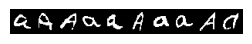

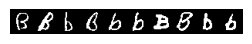

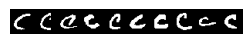

In [2]:
path = "emnist_to_mnist_unet_ConstantThermostat_gamma_0.5_max_0.0/run"
A = get_mnist_test_samples(path, which='source', class_label=1, sample_size=10, device="cuda:0")
B = get_mnist_test_samples(path, which='source', class_label=2, sample_size=10, device="cuda:0")
C = get_mnist_test_samples(path, which='source', class_label=3, sample_size=10, device="cuda:0")
mnist_grid(A, nrow=10, num_img=10, figsize=(3,3))
mnist_grid(B, nrow=10, num_img=10, figsize=(3,3))
mnist_grid(C, nrow=10, num_img=10, figsize=(3,3))

target data:

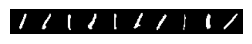

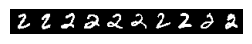

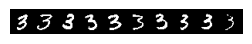

In [3]:
path = "emnist_to_mnist_unet_ConstantThermostat_gamma_0.5_max_0.0/run"
I = get_mnist_test_samples(path, which='target', class_label=1, sample_size=10, device="cuda:0")
II = get_mnist_test_samples(path, which='target', class_label=2, sample_size=10, device="cuda:0")
III = get_mnist_test_samples(path, which='target', class_label=3, sample_size=10, device="cuda:0")
mnist_grid(I, nrow=10, num_img=10, figsize=(3,3))
mnist_grid(II, nrow=10, num_img=10, figsize=(3,3))
mnist_grid(III, nrow=10, num_img=10, figsize=(3,3))

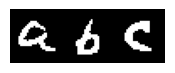

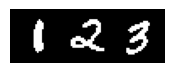

In [7]:
source_ABC = torch.cat([A[0].unsqueeze(0), 
                        B[-1].unsqueeze(0), 
                        C[-1].unsqueeze(0)], dim=0)  
mnist_grid(source_ABC, nrow=3, num_img=3, figsize=(2,1))

target_123 = torch.cat([I[-2].unsqueeze(0), 
                        II[4].unsqueeze(0), 
                        III[0].unsqueeze(0)], dim=0)  
mnist_grid(target_123, nrow=3, num_img=3, figsize=(2,1))

In [8]:
source_black = torch.zeros_like(source_ABC)
source = torch.cat([source_ABC, source_black], dim=0)
target = torch.cat([target_123, target_123], dim=0)

# Markov interpolators

1000it [00:01, 509.77it/s]


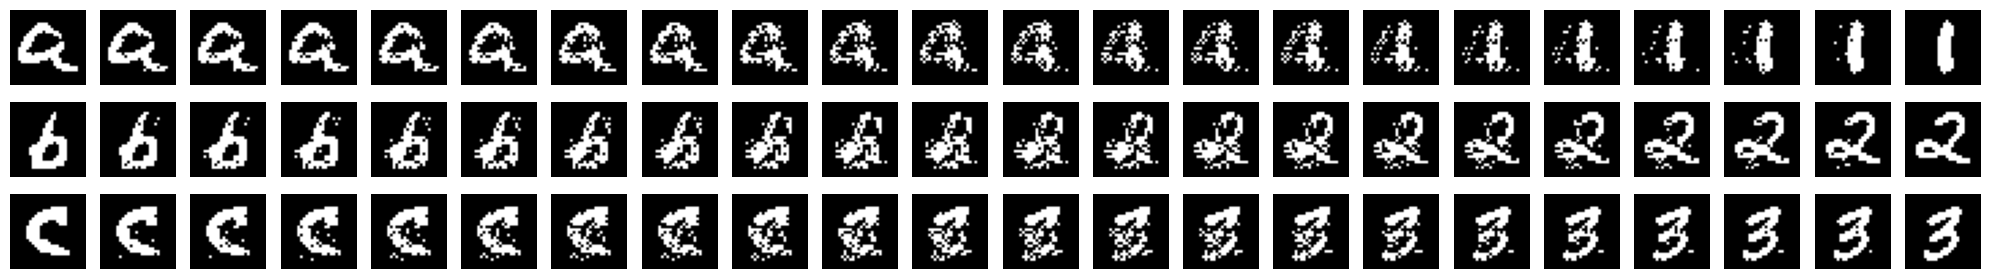

1000it [00:01, 588.18it/s]


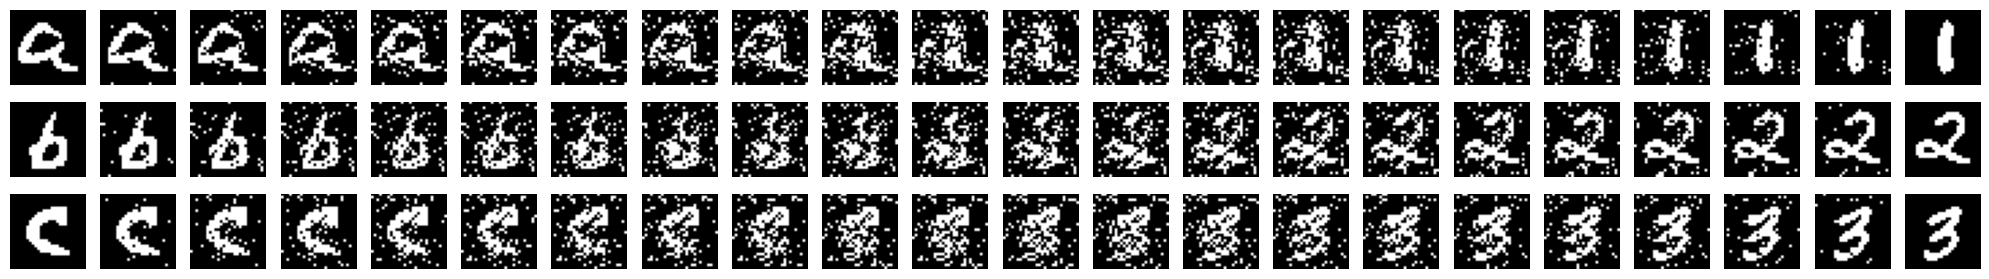

In [12]:

mnist_conditional_bridge(source_ABC, target_123, thermostat="constant", thermostat_params=(.001, 0.0), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat="constant", thermostat_params=(.75, 0.0), num_timesteps=1000, num_timesteps_displayed=20)


1000it [00:21, 47.50it/s]


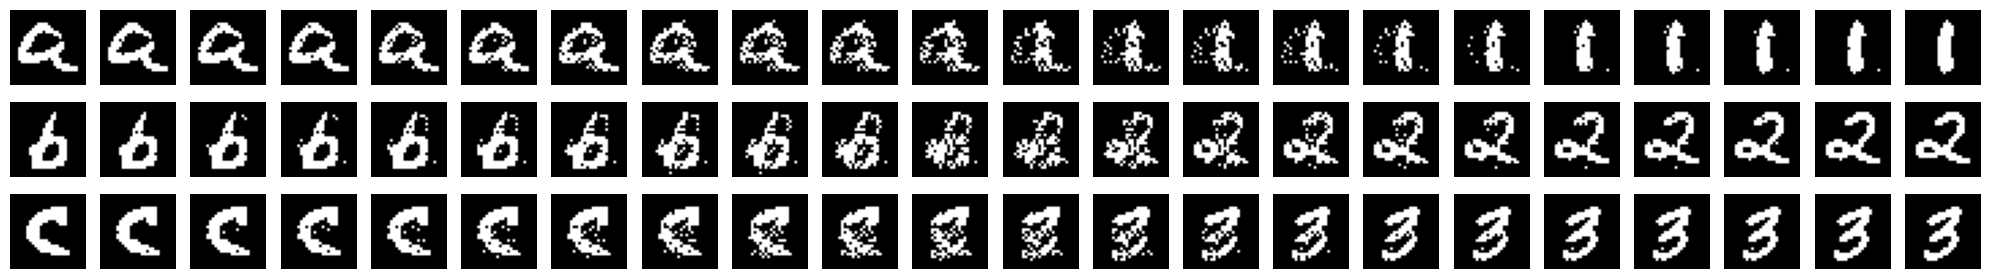

1000it [00:21, 47.54it/s]


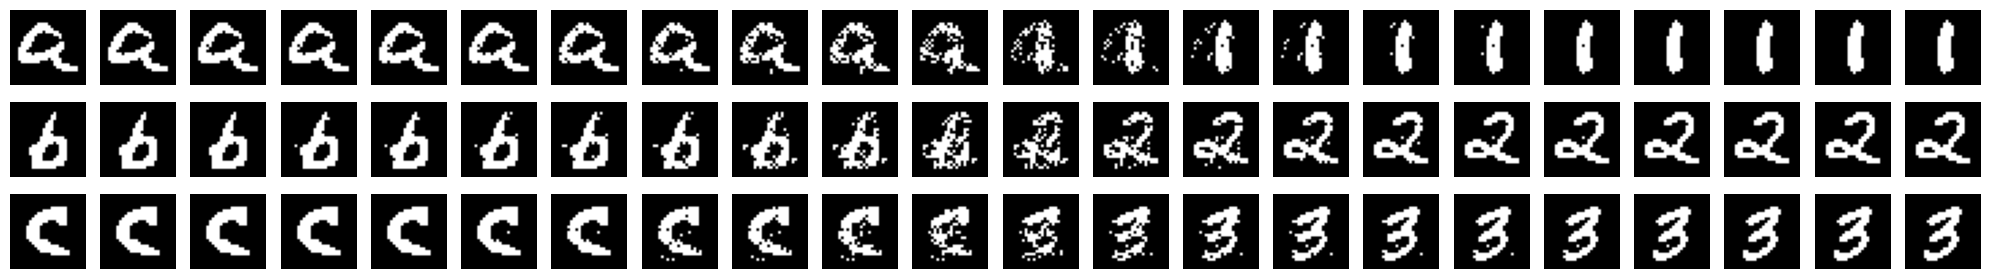

1000it [00:24, 40.87it/s]


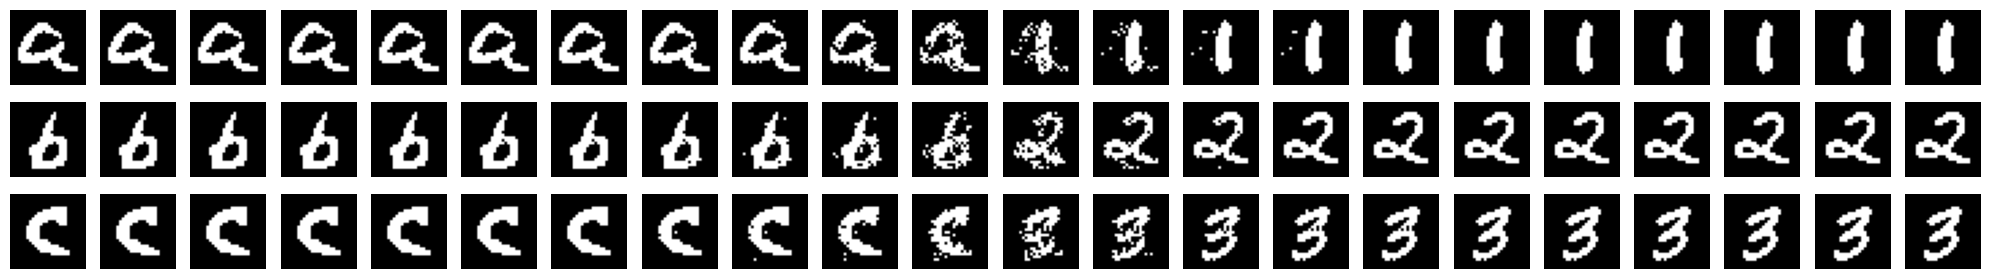

In [14]:
mnist_conditional_bridge(source_ABC, target_123, thermostat='exponential', thermostat_params=(5.0, 0.1), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat='exponential',  thermostat_params=(10.0, 0.1), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat='exponential', thermostat_params=(20.0, .1), num_timesteps=1000, num_timesteps_displayed=20)

1000it [00:23, 42.38it/s]


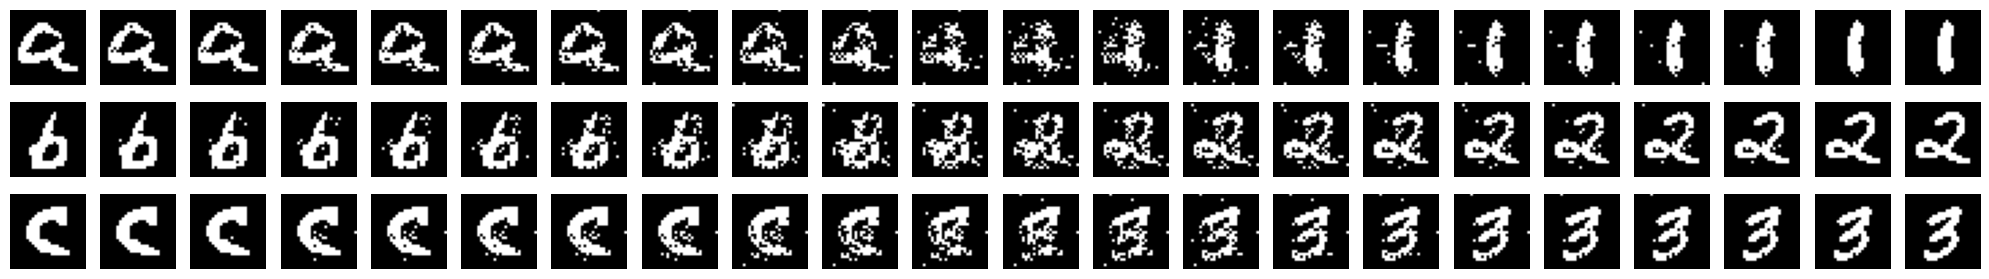

1000it [00:20, 48.90it/s]


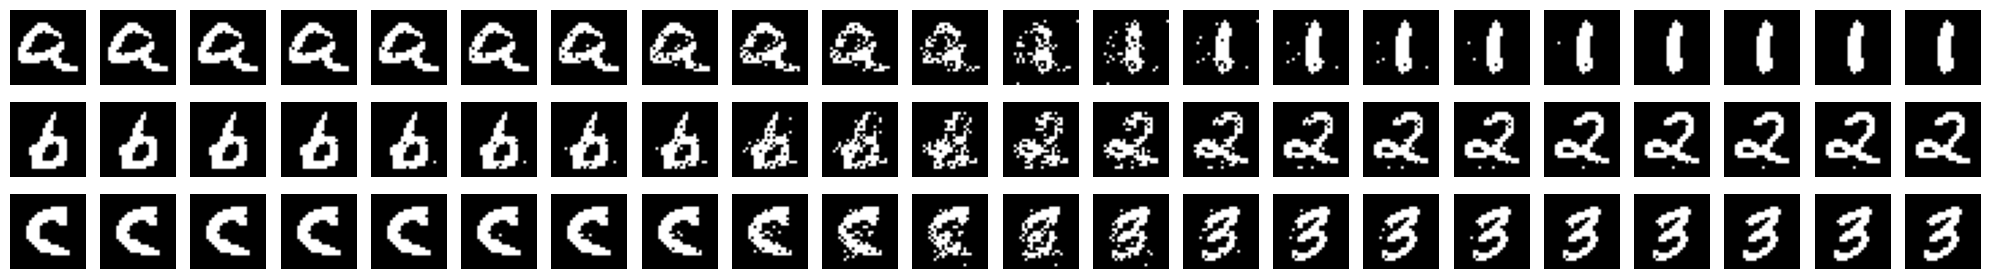

1000it [00:19, 50.16it/s]


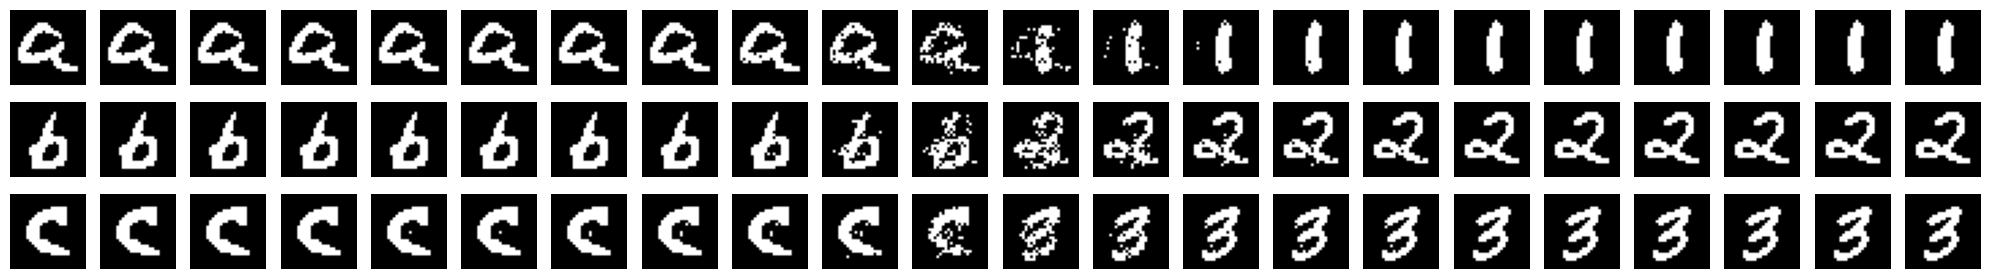

In [15]:
mnist_conditional_bridge(source_ABC, target_123, thermostat='exponential', thermostat_params=(5.0, 0.5), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat='exponential',  thermostat_params=(10.0, 0.5), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat='exponential', thermostat_params=(20.0, .5), num_timesteps=1000, num_timesteps_displayed=20)

1000it [00:02, 431.07it/s]


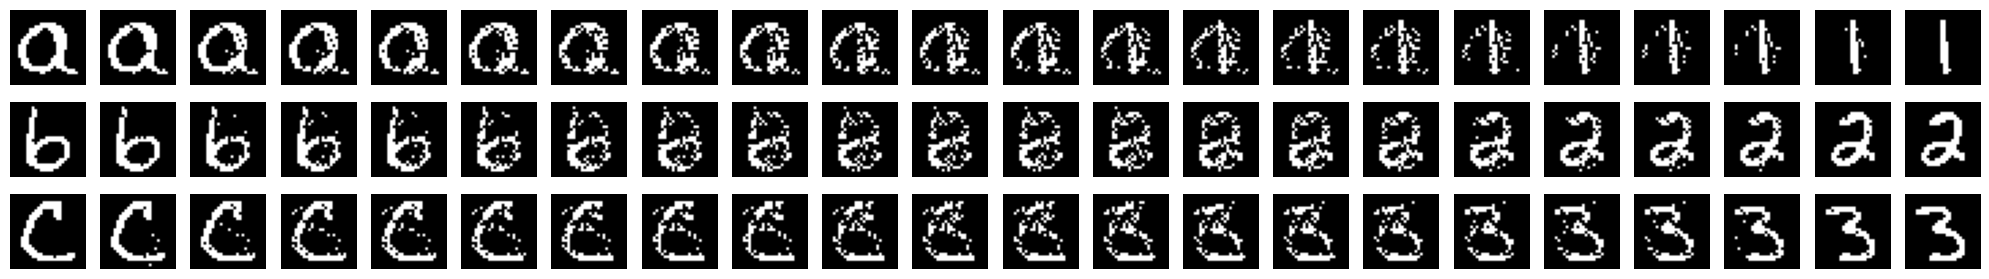

1000it [00:01, 505.94it/s]


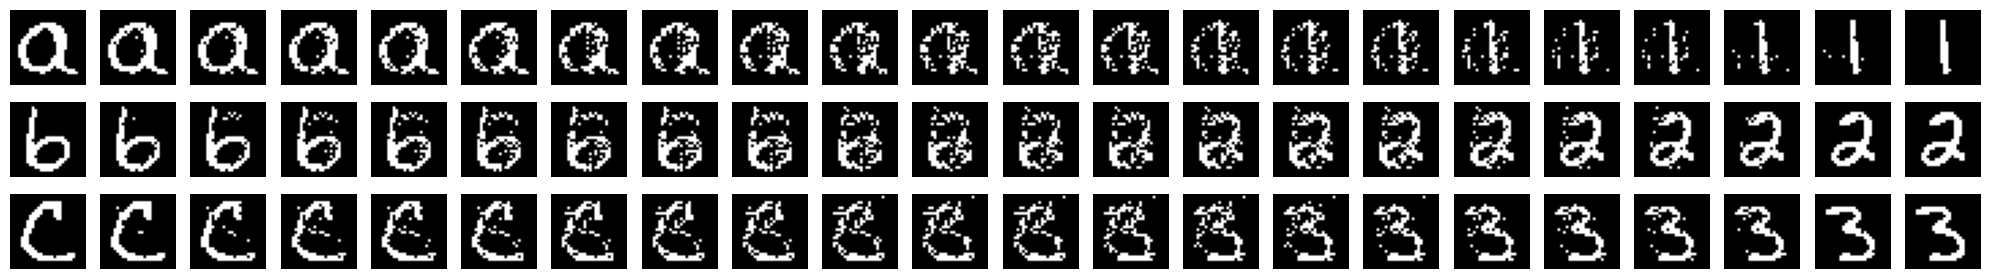

1000it [00:02, 479.84it/s]


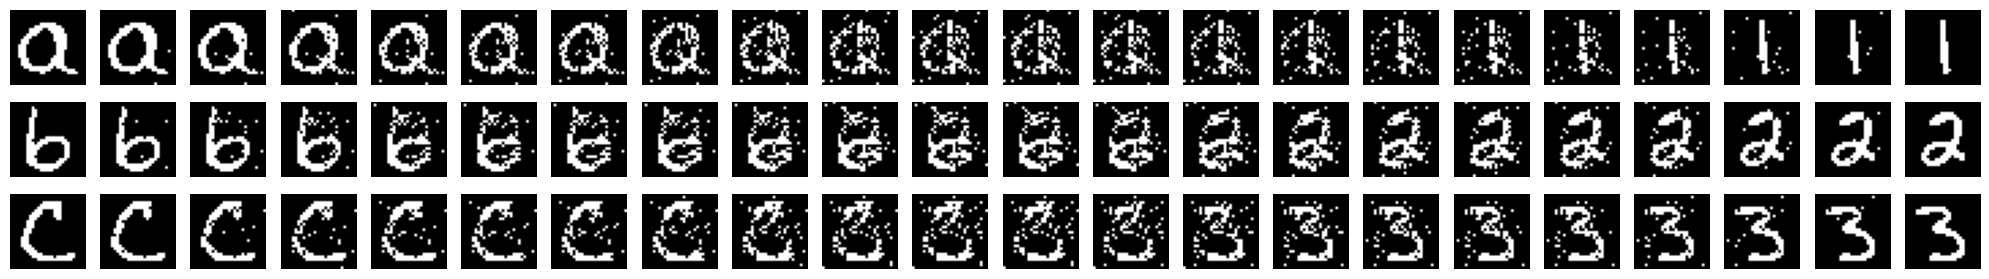

1000it [00:01, 537.63it/s]


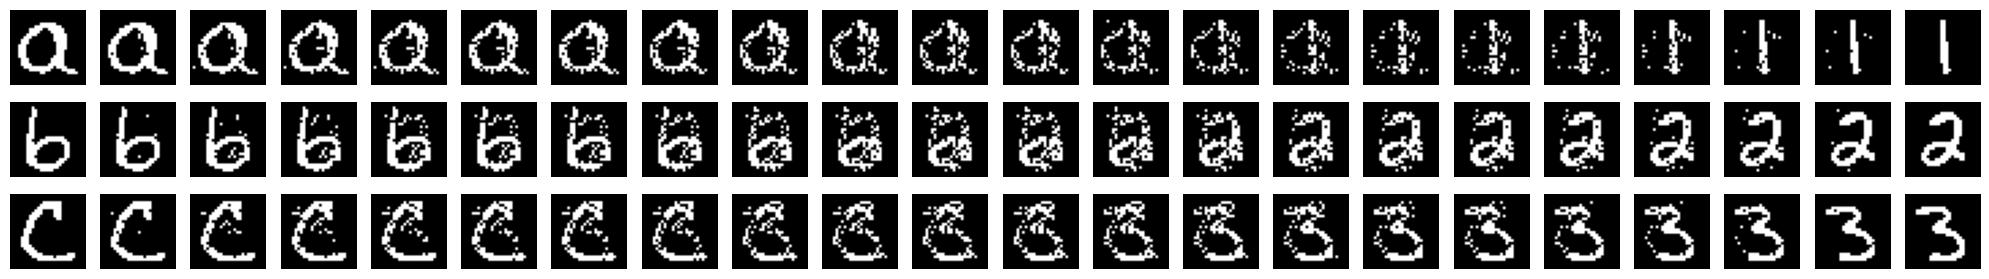

In [10]:
mnist_conditional_bridge(source_ABC, target_123, thermostat='periodic', thermostat_params=(6.0, 0.05), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat='periodic',  thermostat_params=(6.0, 0.1), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat='periodic', thermostat_params=(4.0, 0.5), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat='periodic', thermostat_params=(4.0, 0.1), num_timesteps=1000, num_timesteps_displayed=20)

1000it [00:01, 539.01it/s]


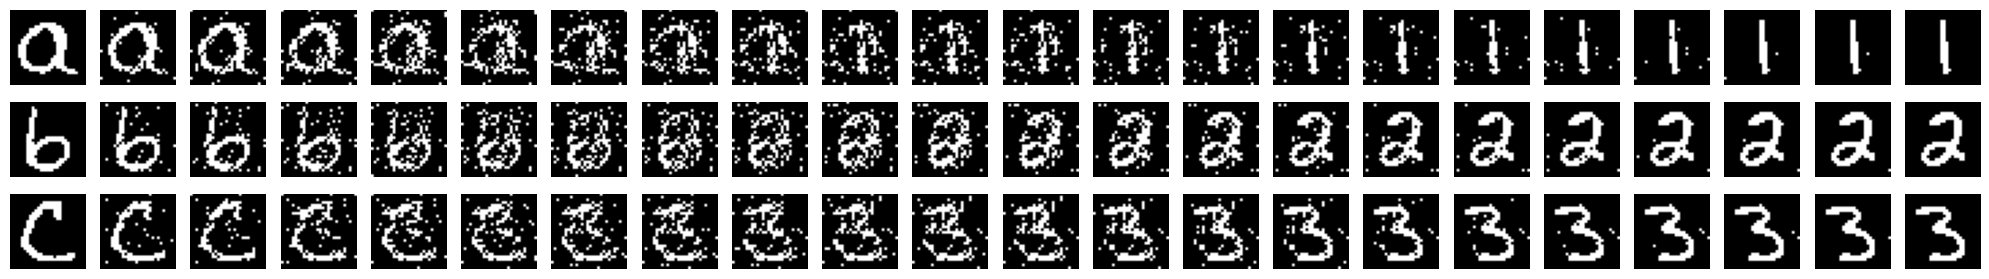

1000it [00:01, 543.19it/s]


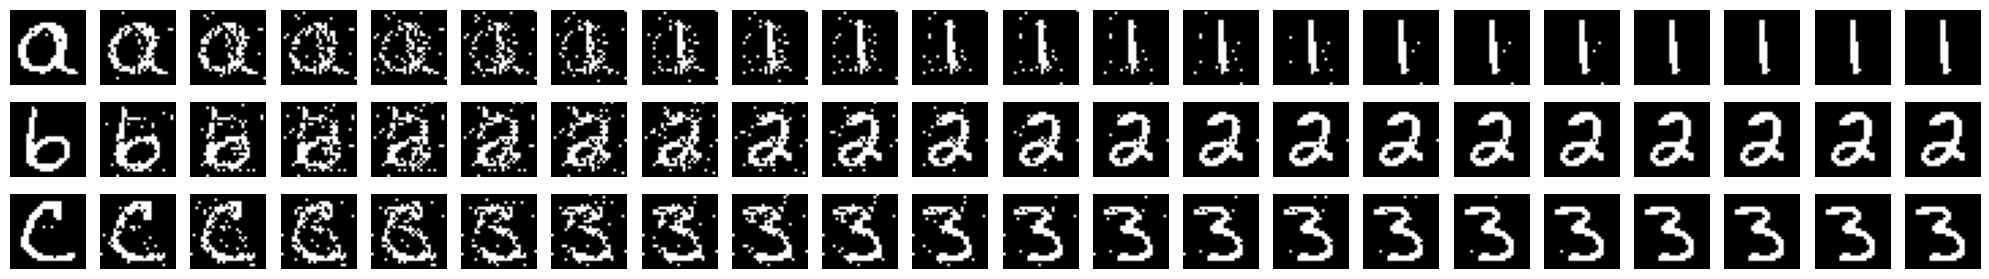

1000it [00:01, 543.70it/s]


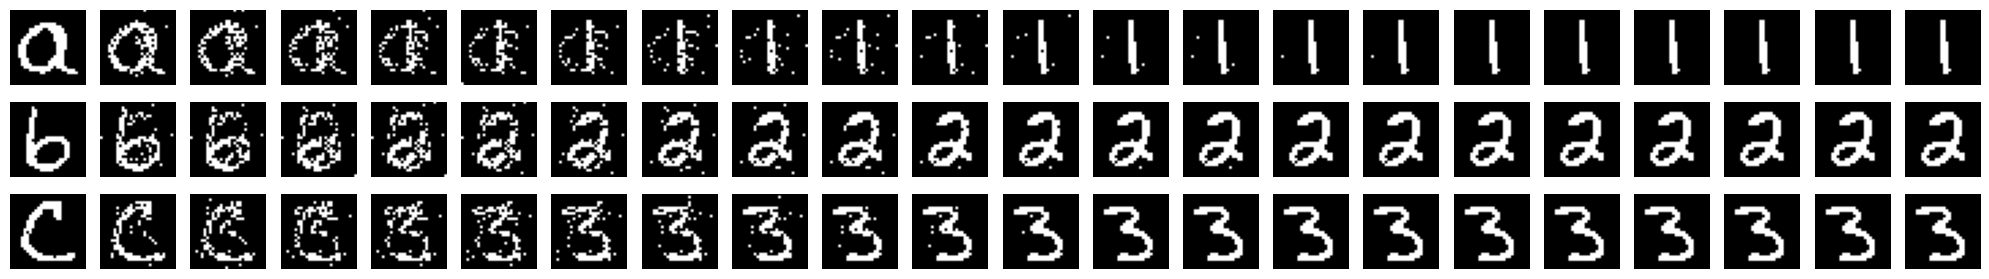

1000it [00:01, 544.77it/s]


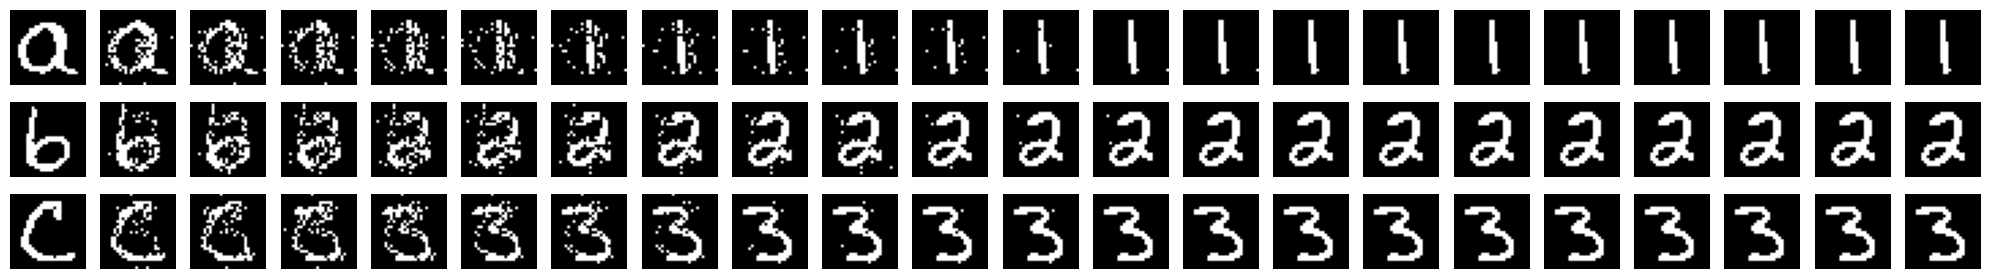

In [13]:
mnist_conditional_bridge(source_ABC, target_123, thermostat='polynomial', thermostat_params=(1,1.0), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat='polynomial', thermostat_params=(1,2.0), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat='polynomial', thermostat_params=(1,3.0), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat='polynomial', thermostat_params=(1,4.0), num_timesteps=1000, num_timesteps_displayed=20)

1000it [00:25, 39.81it/s]


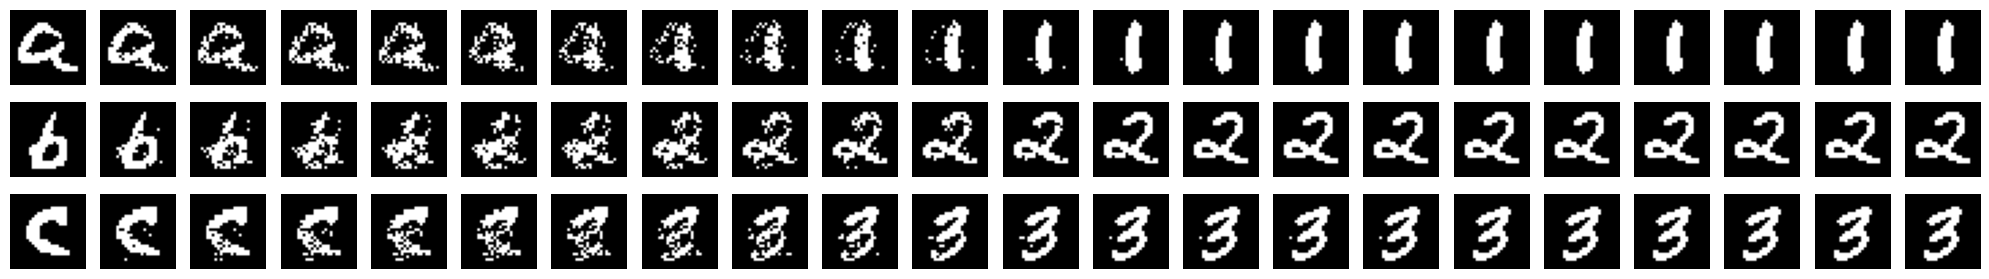

1000it [00:26, 37.41it/s]


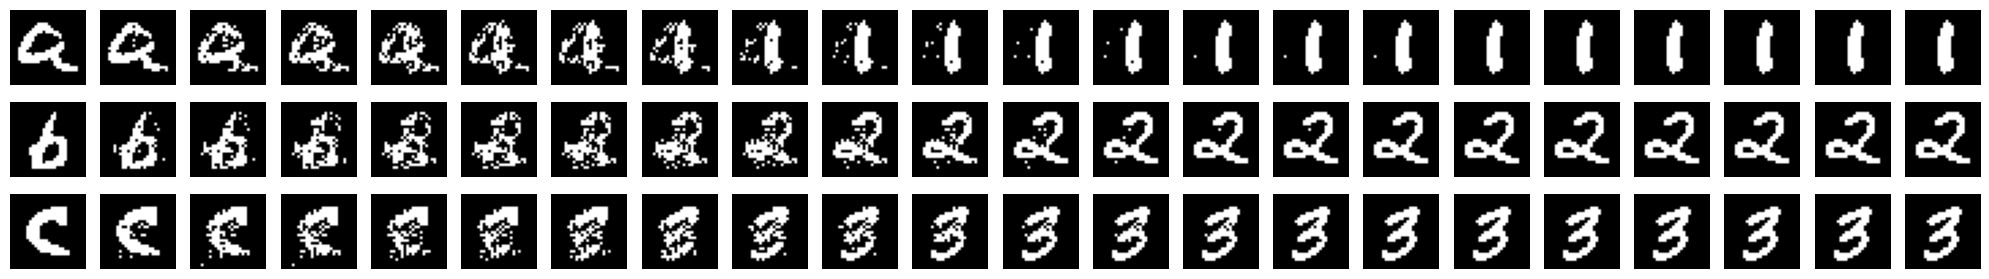

1000it [00:26, 37.30it/s]


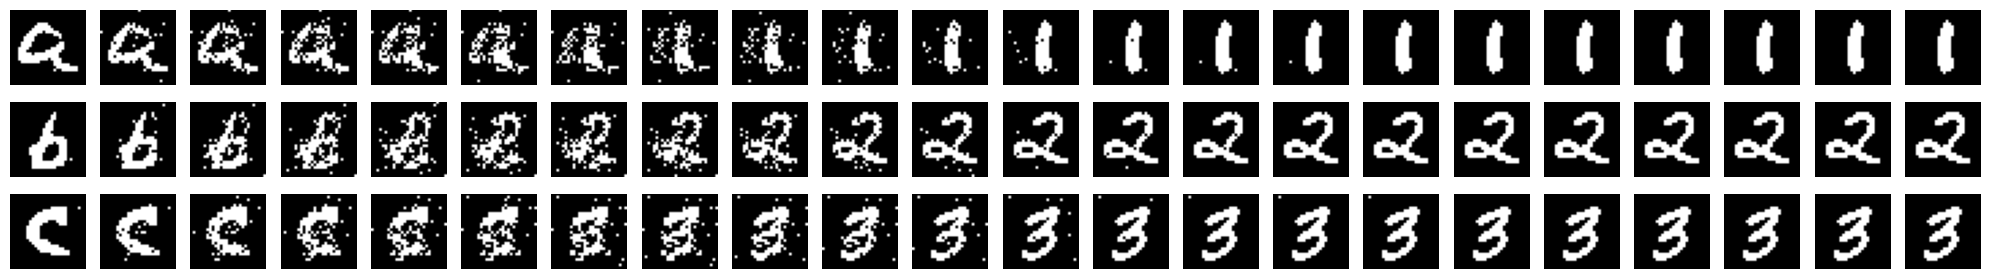

1000it [00:26, 38.20it/s]


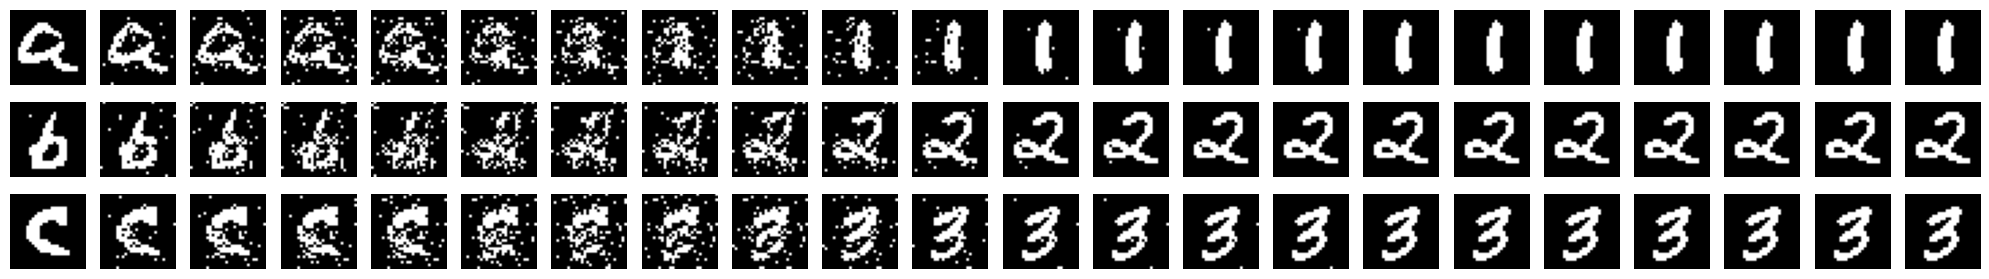

In [10]:
mnist_conditional_bridge(source_ABC, target_123, thermostat='plateau', thermostat_params=(0.01, 20.0, 0.5), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat='plateau', thermostat_params=(0.1, 20.0, 0.5), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat='plateau', thermostat_params=(0.5, 20.0, 0.5), num_timesteps=1000, num_timesteps_displayed=20)
mnist_conditional_bridge(source_ABC, target_123, thermostat='plateau', thermostat_params=(1.0, 29.0, 0.5), num_timesteps=1000, num_timesteps_displayed=20)

100%|██████████| 999/999 [00:07<00:00, 135.41it/s]


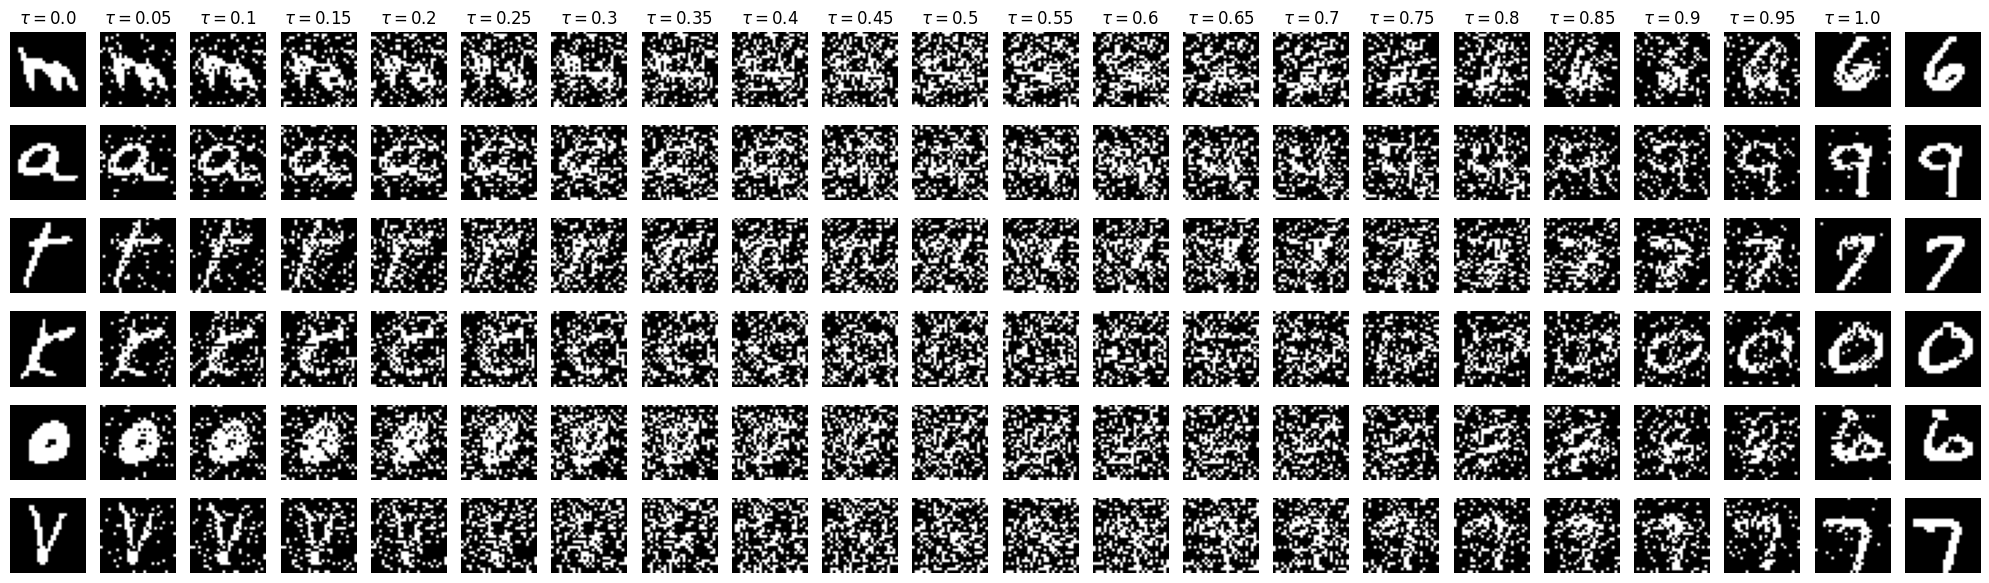

In [ ]:
mnist_noise_bridge(path, markov, 
                   time_epsilon=0.005,
                   num_img=6, 
                   num_timesteps_displayed=20) 

constant thermostat with: $\gamma=0.05$:

100%|██████████| 999/999 [00:35<00:00, 28.33it/s]


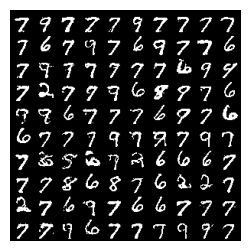

In [ ]:
path = "emnist_to_mnist_unet_ConstantThermostat_gamma_0.05_max_0.0/run"
samples,_ , _ = generate_samples(path, letters, num_timesteps=1000,  time_epsilon=0.05, device="cuda:0")
mnist_grid(samples, num_img=100, nrow=10, figsize=(3,3))

100%|██████████| 999/999 [00:07<00:00, 133.71it/s]


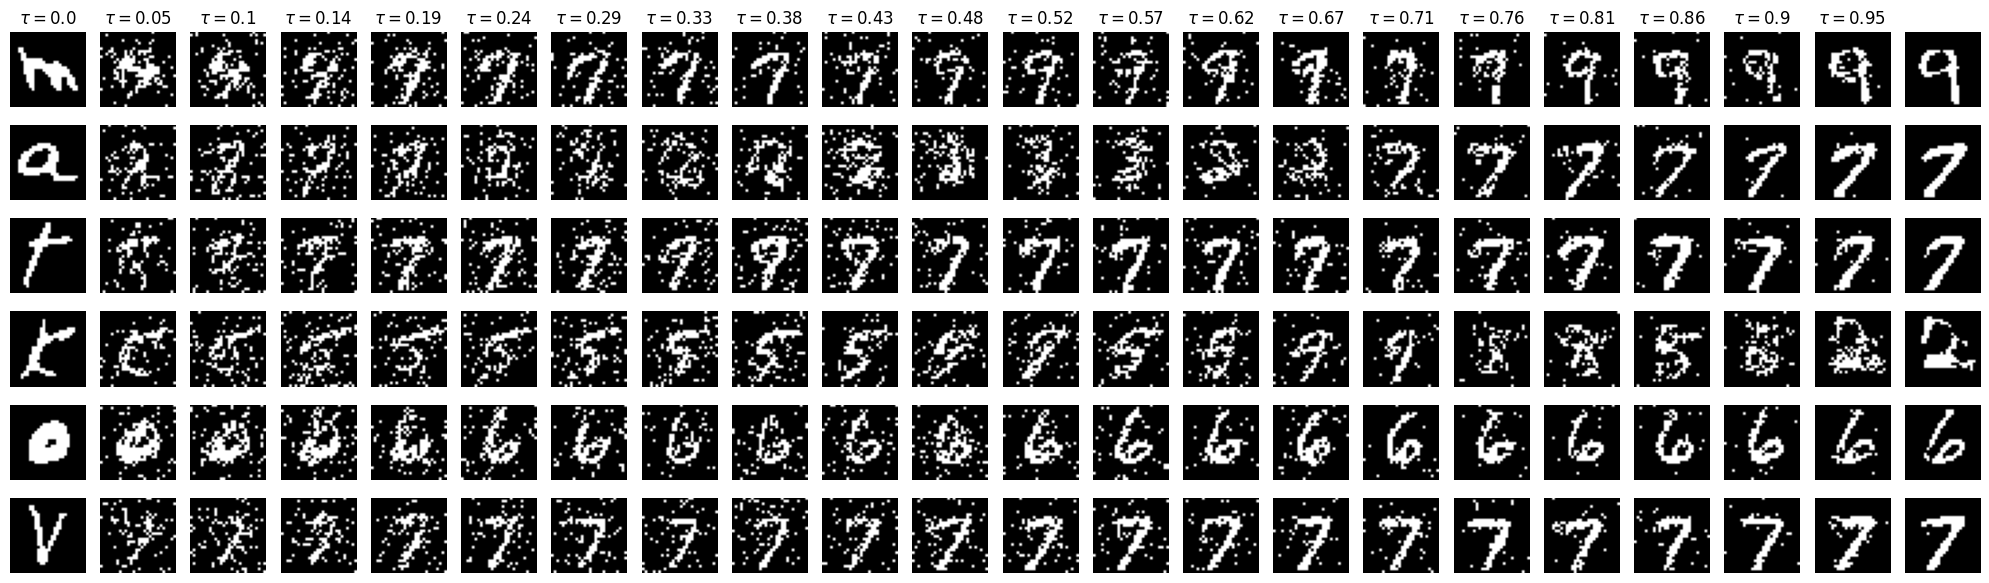

In [ ]:
mnist_noise_bridge(path, markov, 
                   time_epsilon=0.05,
                   num_img=6, 
                   num_timesteps_displayed=20) 

In [ ]:
( 0.012719820159551531+0.005203076233428194+ 0.0031387108202969305)/3
(0.024730698517398286+ 0.06366639819603803 + 0.005837335428029222)/3
(0.006936454942291004+0.009144647920683813+ 0.0015)/3

0.005860367620991606

In [ ]:
path = "distorted_2_mnist_bridge/halfmask_mnist_to_mnist_mlp_0.01/run"
digits = get_mnist_test_samples(path, class_label=None, sample_size=100, device="cuda:0")
mnist_grid(digits, nrow=10, num_img=100, figsize=(3,3))

TypeError: BasicPipelineConfig.__init__() got an unexpected keyword argument 'time_epsilon'

In [ ]:
 (0.013834118554689634+ 0.04626179769806982+0.025443381534919096)/3

0.028513099262559516

In [ ]:
path = "mnist/uniform_coupling/noise_to_mnist_unet_cfm_1.0/run"

noise = get_mnist_test_samples(path, class_label=None, sample_size=100, device="cuda:1")
mnist_grid(noise, nrow=10, num_img=100, figsize=(3,3))

samples,_ , _ = generate_samples(path, noise, num_timesteps=1000,  time_epsilon=0.1, device="cuda:1")
mnist_grid(samples, num_img=100, nrow=10, figsize=(3,3))

samples,_ , _ = generate_samples(path, noise, num_timesteps=1000,  time_epsilon=0.05, device="cuda:1")
mnist_grid(samples, num_img=100, nrow=10, figsize=(3,3))

samples,_ , _ = generate_samples(path, noise, num_timesteps=1000,  time_epsilon=0.02, device="cuda:1")
mnist_grid(samples, num_img=100, nrow=10, figsize=(3,3))

samples,_ , _ = generate_samples(path, noise, num_timesteps=1000,  time_epsilon=0.01, device="cuda:1")
mnist_grid(samples, num_img=100, nrow=10, figsize=(3,3))

samples,_ , _ = generate_samples(path, noise, num_timesteps=1000,  time_epsilon=0.0, device="cuda:1")
mnist_grid(samples, num_img=100, nrow=10, figsize=(3,3))